# Import the libraries 


Our work is highly motivated by https://arxiv.org/pdf/2001.03674.pdf and some of the codes are borrowed from https://github.com/Jimit-Bavishi/extend-ai-ml-assessment/blob/main/extend_ai_assessment.ipynb


In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import os
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch


# Display one image and get the dimensions
Before we start, we first select all of the images without anomalies and put them into train folder, then we select all of the images with anomalies and save them in a val folder. After finishing manipulate the images, we choose one image to display it and obtain it's dimension.

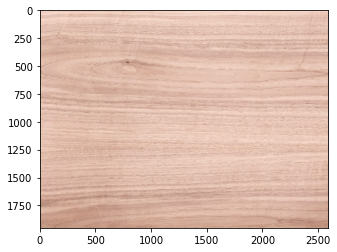

In [48]:
filepath = 'C:\\Users\\14590\\Downloads\\extend-ai-ml-assessment-main\\anomaly-detection-using-autoencoders-master\\data\\train'
sample_image = datasets.ImageFolder(filepath)[0][0]
width, height = sample_image.size
plt.imshow(sample_image)


# Data augmentation
We use the same augmentaion skills as previous work(resize,horizontal and vertical flip, add Gaussian noise) to create a new larger training set. 

In [3]:
image_transforms = [
  transforms.Compose([transforms.ToTensor()]),
  transforms.Compose([transforms.CenterCrop((height//2, width//2)), transforms.Resize((height, width)), transforms.ToTensor()]),
  transforms.Compose([transforms.RandomCrop((height//2, width//2)), transforms.Resize((height, width)), transforms.ToTensor()]),
  transforms.Compose([transforms.RandomHorizontalFlip(1.0), transforms.ToTensor()]),
  transforms.Compose([transforms.RandomVerticalFlip(1.0), transforms.ToTensor()]),
  transforms.Compose([transforms.GaussianBlur(kernel_size=(3,3)), transforms.ToTensor()]),
]


In [4]:
list_datasets = []
filepath = 'C:\\Users\\14590\\Downloads\\extend-ai-ml-assessment-main\\anomaly-detection-using-autoencoders-master\\data\\train'
for transform in image_transforms:
  dataset = datasets.ImageFolder(filepath, transform=transform)
  list_datasets.append(dataset)
augmented_dataset = torch.utils.data.ConcatDataset(list_datasets)
dataloader = torch.utils.data.DataLoader(augmented_dataset)
print(f"Number of images in the augmented dataset is {len(dataloader)}")


Number of images in the augmented dataset is 18


# Build the AnomalyAE model
Our model architecture is as follow: 
As our GPU memory limits, we simply reduce the channel size to allow it fits our GPU memory so that we can use GPU to train the model. 
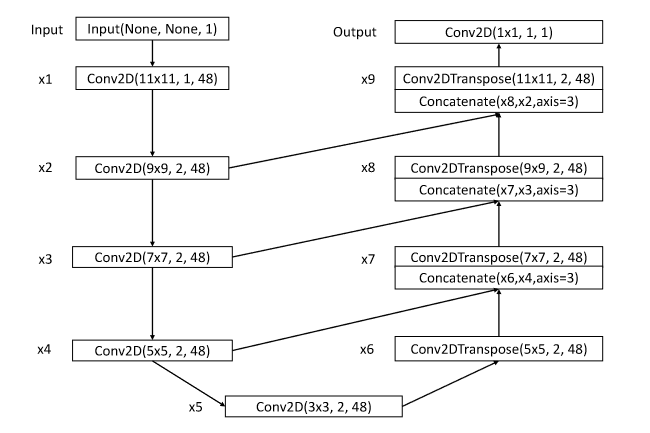
The proposed network is similar to the UNet architecture. The encoder (layers x1 to x5) uses progressively decreasing filter sizes from 11×11 to 3×3. The decoder structure has kernel sizes that are in the reverse of the encoder order and uses
Transposed Convolution Layers. The output from the encoder layers is concatenated with the previous layers before passing to layers x7 to x9. For every Conv2D(Transpose) layer the parameters shown are kernel size, stride and number of filters for that layer. After every layer, batch normalization is applied which is followed by the ReLU activation function. For a H×W×C input the network outputs a H×W×C reconstruction. The network is trained on only the defect-free or normal data samples.

In [5]:


class AnomalyAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, (11, 11), stride=(1, 1), padding=5)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 8, (9, 9), stride=(2, 2), padding=4)
        self.bn2 = nn.BatchNorm2d(8)

        self.conv3 = nn.Conv2d(8, 8, (7, 7), stride=(2, 2), padding=3)
        self.bn3 = nn.BatchNorm2d(8)

        self.conv4 = nn.Conv2d(8, 8, (5, 5), stride=(2, 2), padding=2)
        self.bn4 = nn.BatchNorm2d(8)

        self.conv5 = nn.Conv2d(8, 8, (3, 3), stride=(2, 2), padding=1)
        self.bn5 = nn.BatchNorm2d(8)

        self.conv_tr1 = nn.ConvTranspose2d(
            8, 8, (5, 5), stride=(2, 2), padding=2, output_padding=1)
        self.bn_tr1 = nn.BatchNorm2d(8)

        self.conv_tr2 = nn.ConvTranspose2d(
            16, 8, (7, 7), stride=(2, 2), padding=3, output_padding=1)
        self.bn_tr2 = nn.BatchNorm2d(8)

        self.conv_tr3 = nn.ConvTranspose2d(
            16, 8, (9, 9), stride=(2, 2), padding=4, output_padding=1)
        self.bn_tr3 = nn.BatchNorm2d(8)

        self.conv_tr4 = nn.ConvTranspose2d(
            16, 8, (11,  11), stride=(2, 2), padding=5, output_padding=1)
        self.bn_tr4 = nn.BatchNorm2d(8)

        self.conv_output = nn.Conv2d(16, 3, (1, 1), (1, 1))
        self.bn_output = nn.BatchNorm2d(3)

    def forward(self, x):
        slope = 0.2
        x = F.leaky_relu((self.bn1(self.conv1(x))), slope)
        x1 = F.leaky_relu((self.bn2(self.conv2(x))), slope)
        x2 = F.leaky_relu((self.bn3(self.conv3(x1))), slope)
        x3 = F.leaky_relu((self.bn4(self.conv4(x2))), slope)
        x4 = F.leaky_relu((self.bn5(self.conv5(x3))), slope)

        x5 = F.leaky_relu(self.bn_tr1(self.conv_tr1(x4)), slope)
        x6 = F.leaky_relu(self.bn_tr2(
            self.conv_tr2(torch.cat([x5, x3], 1))), slope)
        x7 = F.leaky_relu(self.bn_tr3(
            self.conv_tr3(torch.cat([x6, x2], 1))), slope)
        x8 = F.leaky_relu(self.bn_tr4(
            self.conv_tr4(torch.cat([x7, x1], 1))), slope)

        output = F.leaky_relu(self.bn_output(
            self.conv_output(torch.cat([x8, x], 1))), slope)
        return output

# Check the inpur and ouput size

In [6]:
untrained_net = AnomalyAE().eval()
sample_image, _ = next(iter(dataloader))
input_image = sample_image[0][None, :, :, :]  # Add extra dimension(batch no.)
output_image = untrained_net.forward(input_image).detach() 

# Dimensions of input and output images should be the same
print(f"Size of input image is {input_image.size()}")
print(f"Size of output image is {output_image.size()}")

Size of input image is torch.Size([1, 3, 1952, 2592])
Size of output image is torch.Size([1, 3, 1952, 2592])


# Display the network(untrained) output vs original image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


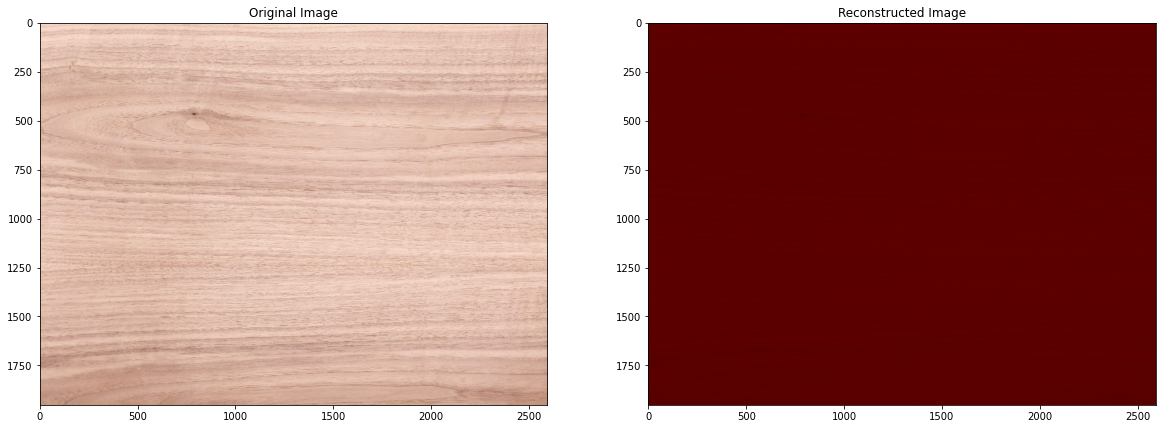

In [7]:
input_image = input_image[0].permute(1, 2, 0)
output_image = output_image[0].permute(1, 2, 0)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Original Image')
ax1.imshow(input_image)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Reconstructed Image')
ax2.imshow(output_image)

# Training process
Train the model using Adam optimizers with MSE loss. As shown in the paper, we train the model for 50 epochs.





In [8]:

def get_optimizer(net, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return optimizer

def train(net, x, y, optimizer, criterion):
    net.zero_grad()
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss, output



In [10]:
net = AnomalyAE() # Initialize an untrained network
net = net.cuda() # Utilize Colab's GPU
optm = get_optimizer(net, lr=0.1)
criterion = nn.MSELoss()
EPOCHS = 50

for epoch in range(EPOCHS):
    epoch_loss = 0
    for img, _ in dataloader:
      img = img.cuda()
      loss, predictions = train(net, img, img, optm, criterion)
      epoch_loss += loss
    print(f'Average MSE Loss per image: {epoch_loss/len(dataloader)}')
net = net.eval()

Average MSE Loss per image: 0.13233067095279694
Average MSE Loss per image: 0.0153006287291646
Average MSE Loss per image: 0.009279758669435978
Average MSE Loss per image: 0.008318427950143814
Average MSE Loss per image: 0.007768518291413784
Average MSE Loss per image: 0.0075011104345321655
Average MSE Loss per image: 0.007201685104519129
Average MSE Loss per image: 0.0069374884478747845
Average MSE Loss per image: 0.006353647448122501
Average MSE Loss per image: 0.006356545723974705
Average MSE Loss per image: 0.0058210561983287334
Average MSE Loss per image: 0.00544556463137269
Average MSE Loss per image: 0.005176586098968983
Average MSE Loss per image: 0.004805433098226786
Average MSE Loss per image: 0.004670822061598301
Average MSE Loss per image: 0.004193677566945553
Average MSE Loss per image: 0.003970869816839695
Average MSE Loss per image: 0.0038636219687759876
Average MSE Loss per image: 0.0034575231838971376
Average MSE Loss per image: 0.0033720575738698244
Average MSE Loss p

# Apply data augmentation on validation set
We also apply data augmentation on validation set to see more visualization results

In [49]:
valid_datasets = []
filepath = 'C:\\Users\\14590\\Downloads\\extend-ai-ml-assessment-main\\anomaly-detection-using-autoencoders-master\\data\\val'
for transform in image_transforms:
    dataset = datasets.ImageFolder(filepath, transform=transform)
    valid_datasets.append(dataset)
augmented_val_dataset = torch.utils.data.ConcatDataset(valid_datasets)
dataloader = torch.utils.data.DataLoader(augmented_val_dataset)
print(f"Number of images in the augmented dataset is {len(dataloader)}")


Number of images in the augmented dataset is 24


# Display results
According to the paper, our hypothesis is that the auto-encoder will learn representations 
that would only be able to encode and decode the normal samples properly and will not
be able to reconstruct the anomalous regions. 
This shall cause large residuals for the defective regions in the residual map 
obtained by subtracting the reconstructed image from the input image as shown in Equation 1. 
The subtraction is done at per pixel-level. This is followed by a thresholding operation to obtain the final defect segmentation. The residual is R = X−AE(X). X is the original input and AE(X) is the output of AnomalyAE model.


In [12]:

def display_images(dataset, index):
    sample_image, _ = dataset[index]
    input_image = sample_image[None, :, :, :]  # Add extra dimension
    output_image = net.forward(input_image.cuda()).detach() 
    input_image = input_image[0].permute(1, 2, 0)
    output_image = output_image[0].cpu().permute(1, 2, 0)
    residual = torch.abs(input_image - output_image)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Original Image')
    ax1.imshow(input_image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Reconstructed Image')
    ax2.imshow(output_image)
    ax2 = fig.add_subplot(1,3,3)
    ax2.set_title('Residual Image')
    ax2.imshow(residual)
    

In [13]:
def return_residual(dataset, index):
    sample_image, _ = dataset[index]
    input_image = sample_image[None, :, :, :]  # Add extra dimension
    output_image = net.forward(input_image.cuda()).detach() 
    input_image = input_image[0].permute(1, 2, 0)
    output_image = output_image[0].cpu().permute(1, 2, 0)
    residual = torch.abs(input_image - output_image)
    return residual

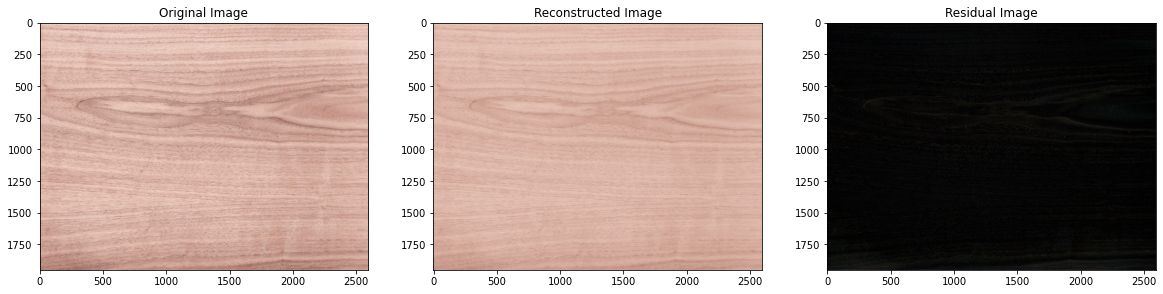

In [43]:
display_images(augmented_dataset, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


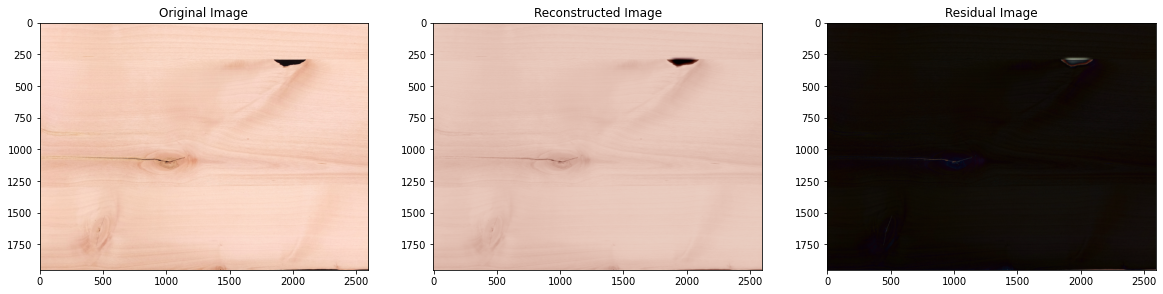

In [45]:
display_images(augmented_val_dataset, 2)

# Thresholding the Residual
We apply residual thresholding to enhance the visual effect of anomalies. The residual threshold is determined by the histogram of the residuals.

(array([1.5014468e+07, 1.3527800e+05, 1.6375000e+04, 6.1620000e+03,
        3.1960000e+03, 1.5570000e+03, 9.0700000e+02, 5.1700000e+02,
        2.4300000e+02, 4.9000000e+01]),
 array([0.        , 0.08988822, 0.17977643, 0.26966465, 0.35955286,
        0.44944108, 0.5393293 , 0.6292175 , 0.7191057 , 0.80899394,
        0.89888215], dtype=float32),
 <BarContainer object of 10 artists>)

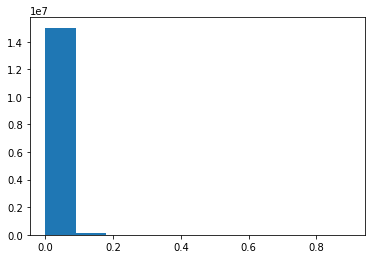

In [46]:
residual = return_residual(augmented_val_dataset,2)
plt.hist(residual.detach().cpu().numpy().ravel())


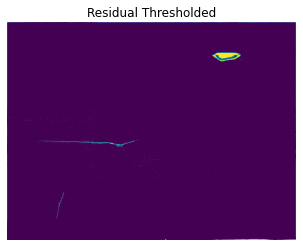

In [47]:
mat = residual.cpu().numpy()
rgb_weights = [0.299, 0.587, 0.114]
grayscale_image = np.dot(mat[...,:3], rgb_weights)
plt.imshow(grayscale_image > 0.09);
plt.title('Residual Thresholded')
plt.axis('off');

# Conclusions

We use AnomalyAE model, which is similar to UNET architecture, to reconstruct the non-defect image of wood texture. Through training on non-defect images, our model can only learn how to encode and decode the normal images. Thus, our model will generate large residuals between original images and predicted images with anomalies. This is an important feature that is essential for practical applications where a limited number of anomalous samples and a large number of normal samples are available. 
For future improvements:
1. We can modify either the architecture or hyperparameters of the model to allow it fit common GPU or system without GPU
2. Our model is able to train with other type of materials from scratch.
3. The selecton of threshold could be more reasonably by using the distribution of all 3-channels instead of converting to gray scale.(And I am surprised that the final redisual output doesn't looks like a grayscale probably because the anomalies may affect differently on r g and b channels.)
